Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.

In [43]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

#### Acquire data

In [44]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [45]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
ip                13978 non-null object
timestamp         13978 non-null object
request_method    13978 non-null object
status            13978 non-null int64
size              13978 non-null int64
destination       25 non-null object
request_agent     13978 non-null object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


#### Parse Datatime

In [46]:
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')

In [47]:
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42+00:00,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:44+00:00,97.105.19.58,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:46+00:00,97.105.19.58,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:48+00:00,97.105.19.58,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [48]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

In [49]:
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales?page=81 HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales?page=82 HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales?page=83 HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales?page=84 HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [50]:
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

In [51]:
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


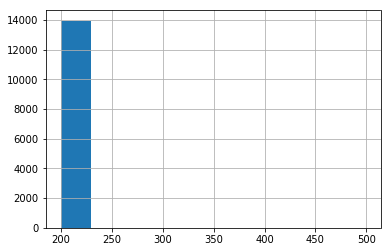

In [52]:
df.status.hist()
plt.show()

In [57]:
df.status.value_counts()

200    13960
499       16
301        2
Name: status, dtype: int64

In [60]:
df [df.status == 301]

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-17 19:36:41+00:00,95.31.16.121,GET /api/v1/sales/HTTP/1.1,301,1005,NaN,python-requests/2.21.0
2019-04-18 19:42:41+00:00,97.105.15.120,GET /api/v1/sales/HTTP/1.1,301,2560,NaN,python-requests/2.21.0


In [61]:
df [df.status == 499]

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:55:15+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,499,0,NaN,python-requests/2.20.1
2019-04-16 19:56:02+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,499,0,NaN,python-requests/2.20.1
2019-04-16 20:28:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,499,0,NaN,python-requests/2.21.0
2019-04-16 20:33:24+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,499,0,NaN,python-requests/2.21.0
2019-04-16 20:38:13+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,499,0,NaN,python-requests/2.21.0
2019-04-16 20:38:55+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,499,0,NaN,python-requests/2.21.0
2019-04-16 20:39:00+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,499,0,NaN,python-requests/2.21.0
2019-04-16 20:45:17+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,499,0,NaN,python-requests/2.21.0
2019-04-16 20:45:28+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,499,0,NaN,python-requests/2.21.0


In [63]:
df.ip.value_counts()

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
24.26.242.9          21
70.121.214.34         2
52.87.230.102         2
35.175.171.137        2
54.172.14.223         1
34.207.64.242         1
54.145.52.184         1
3.92.201.136          1
52.91.30.150          1
97.105.15.120         1
45.23.250.16          1
3.88.129.158          1
95.31.18.119          1
95.31.16.121          1
52.90.165.200         1
35.174.209.2          1
34.229.70.250         1
Name: ip, dtype: int64

In [65]:
df.request_agent.value_counts()

python-requests/2.21.0                                                                                                       12005
python-requests/2.20.1                                                                                                        1911
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36       34
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                               8
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                       7
Slackbot 1.0 (+https://api.slack.com/robots)                                                                                     6
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36        4
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gec

In [75]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [77]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246


In [78]:
df.size_mb.value_counts(bins=10, sort=False)

(-0.00296, 0.196]     1588
(0.196, 0.392]          70
(0.392, 0.588]       12318
(0.588, 0.784]           0
(0.784, 0.981]           0
(0.981, 1.177]           1
(1.177, 1.373]           0
(1.373, 1.569]           0
(1.569, 1.765]           0
(1.765, 1.961]           1
Name: size_mb, dtype: int64

In [81]:
# see range of dates
df.sort_index()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246
...,...,...,...,...,...,...,...
2019-04-17 12:55:14+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510166,NaN,python-requests/2.21.0,0.486532
2019-04-17 19:36:41+00:00,95.31.16.121,GET /api/v1/sales/HTTP/1.1,301,1005,NaN,python-requests/2.21.0,0.000958
2019-04-18 19:42:41+00:00,97.105.15.120,GET /api/v1/sales/HTTP/1.1,301,2560,NaN,python-requests/2.21.0,0.002441


In [79]:
df.groupby(df.index.dayofweek).count()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
1,11947,11947,11947,11947,22,11947,11947
2,2028,2028,2028,2028,3,2028,2028
3,1,1,1,1,0,1,1
4,1,1,1,1,0,1,1
6,1,1,1,1,0,1,1


Dataset doesn't include monday traffic. Majority of traffic on Tuesday and Wednesday. 

In [91]:
df.destination.value_counts(dropna=False)

NaN                                                             13953
https://python.zach.lol/                                            4
https://ds.codeup.com/8.3_Acquire/                                  3
https://python.zach.lol/api/v1/stores?page=1                        2
https://python.zach.lol/api/v1/                                     2
https://python.zach.lol/api/v1//api/v1/items/next_page              1
https://python.zach.lol/api/v1/sales?page=3                         1
http://localhost:8888/notebooks/acquire.ipynb                       1
https://python.zach.lol/api/v1/items                                1
https://python.zach.lol/api/v1/I_DIDNT_DO_IT!!!!                    1
https://python.zach.lol/api/v1/stores?page=0                        1
https://python.zach.lol/api/v1/stores?page=2                        1
https://python.zach.lol/api/v1//api/v1/items?page=2                 1
https://python.zach.lol/api/v1/stores?page=999                      1
https://python.zach.

In [24]:
df.request_method.value_counts()

GET /api/v1/sales HTTP/1.1                      12403
GET /api/v1/items HTTP/1.1                       1065
GET /api/v1/stores HTTP/1.1                       229
GET / HTTP/1.1                                    107
GET /documentation HTTP/1.1                       100
GET /favicon.ico HTTP/1.1                          26
GET /api/v1//api/v1/items HTTP/1.1                 11
GET /api/v1/items/api/v1/items HTTP/1.1             7
GET /api/v1/items/next_page HTTP/1.1                5
GET /api/v1/ HTTP/1.1                               4
GET /api/v1/store HTTP/1.1                          3
GET /api/v1/sales/ HTTP/1.1                         3
GET /api/v1/sales/HTTP/1.1                          3
GET /api/v1/itemsitems HTTP/1.1                     3
GET /api/v1items HTTP/1.1                           2
GET /api/v1//api/v1/items/next_page HTTP/1.1        1
GET /api/v1/items&page=0 HTTP/1.1                   1
GET /api/v1/helloclass! HTTP/1.1                    1
GET /api/v1 HTTP/1.1        

In [82]:
df.parts = df.request_method.str.split(" ")
df.parts

timestamp
2019-04-16 19:34:42+00:00    [GET, /api/v1/sales, HTTP/1.1]
2019-04-16 19:34:42+00:00    [GET, /api/v1/items, HTTP/1.1]
2019-04-16 19:34:44+00:00    [GET, /api/v1/sales, HTTP/1.1]
2019-04-16 19:34:46+00:00    [GET, /api/v1/sales, HTTP/1.1]
2019-04-16 19:34:48+00:00    [GET, /api/v1/sales, HTTP/1.1]
                                          ...              
2019-04-17 12:55:14+00:00    [GET, /api/v1/sales, HTTP/1.1]
2019-04-21 10:02:41+00:00     [GET, /api/v1/items/HTTP/1.1]
2019-04-17 19:36:41+00:00     [GET, /api/v1/sales/HTTP/1.1]
2019-04-18 19:42:41+00:00     [GET, /api/v1/sales/HTTP/1.1]
2019-04-19 19:42:41+00:00     [GET, /api/v1/sales/HTTP/1.1]
Name: request_method, Length: 13978, dtype: object

In [83]:
def get_first(some_list):
    return some_list[0]

In [86]:
df["http_method"] = df.parts.apply(get_first)
df.http_method

timestamp
2019-04-16 19:34:42+00:00    GET
2019-04-16 19:34:42+00:00    GET
2019-04-16 19:34:44+00:00    GET
2019-04-16 19:34:46+00:00    GET
2019-04-16 19:34:48+00:00    GET
                            ... 
2019-04-17 12:55:14+00:00    GET
2019-04-21 10:02:41+00:00    GET
2019-04-17 19:36:41+00:00    GET
2019-04-18 19:42:41+00:00    GET
2019-04-19 19:42:41+00:00    GET
Name: http_method, Length: 13978, dtype: object

In [87]:
df.http_method.value_counts()

GET    13978
Name: http_method, dtype: int64

In [88]:
df["endpoints"] = df.parts.apply(lambda x: x[1])

In [89]:
df.endpoints.value_counts()

/api/v1/sales                      12403
/api/v1/items                       1065
/api/v1/stores                       229
/                                    107
/documentation                       100
/favicon.ico                          26
/api/v1//api/v1/items                 11
/api/v1/items/api/v1/items             7
/api/v1/items/next_page                5
/api/v1/                               4
/api/v1/sales/HTTP/1.1                 3
/api/v1/itemsitems                     3
/api/v1/store                          3
/api/v1/sales/                         3
/api/v1items                           2
/api/V1/HiZach!                        1
/api/v1//api/v1/items/next_page        1
/api/v1/items&page=0                   1
/api/v1                                1
/api/v1/I_DIDNT_DO_IT!!!!              1
/api/v1/helloclass!                    1
/api/v1/items/HTTP/1.1                 1
Name: endpoints, dtype: int64

In [90]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,http_method,endpoints
timestamp,,,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753,GET,/api/v1/sales
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396,GET,/api/v1/items
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472,GET,/api/v1/sales
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377,GET,/api/v1/sales
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246,GET,/api/v1/sales
